In [3]:
import os
import csv
import torch
import librosa
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torch
import shutil
from jiwer import wer, cer
from datasets import Dataset
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union
from transformers import TrainingArguments, Trainer
import transformers
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, Trainer, TrainingArguments

from P2_Transformers_Speech_Classification.visualizations import vis_accuracy_cer, vis_silence_detection_accuracy
from create_datasets import create_silence_detection_list, create_dataset, \
    train_test_split_silence_detection, create_dataset_silence_classification
from project_2 import *
from transformers import TrainerCallback, TrainerControl

In [4]:
os.getcwd()

'C:\\Users\\wojew\\Documents\\DS\\sem1\\Deep Learning\\CINIC10_Proj1\\P2_Transformers_Speech_Classification'

# Load model

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
model.to(device)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You sho

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

### Predict single audio

In [4]:
predict_single_audio(model, processor, 'data/train/audio/happy/0ab3b47d_nohash_0.wav')

Transcription for data/train/audio/happy/0ab3b47d_nohash_0.wav: HAPPY


'HAPPY'

# Datasets
### Create & save datasets

In [5]:
audio_dir = "data/train/audio/" 

#### Datasets without silence

In [ ]:
audio_dir = "data/train/audio/" 
dataset_train = create_dataset(audio_dir, processor, 'training_list')
dataset_train.save_to_disk('./dataset_train')

In [ ]:
dataset_valid = create_dataset(audio_dir, processor, 'validation_list')
dataset_valid.save_to_disk('./dataset_valid')

In [ ]:
dataset_test = create_dataset(audio_dir, processor, 'testing_list')
dataset_test.save_to_disk('./dataset_test')

#### Silence detection datasets

In [3]:
create_silence_detection_list()
train_test_split_silence_detection()

In [8]:
dataset_train_silence_detection = create_dataset_silence_classification(audio_dir, processor, 'train_silence_detection_list')
dataset_train_silence_detection.save_to_disk('./dataset_train_silence_detection')

Saving the dataset (1/1 shards): 100%|██████████| 1920/1920 [00:00<00:00, 21606.84 examples/s]


In [9]:
dataset_test_silence_detection = create_dataset_silence_classification(audio_dir, processor, 'test_silence_detection_list')
dataset_test_silence_detection.save_to_disk('./dataset_test_silence_detection')

Saving the dataset (1/1 shards): 100%|██████████| 480/480 [00:00<00:00, 25263.72 examples/s]


### Load datasets

In [4]:
dataset_train = Dataset.load_from_disk("./dataset_train")
dataset_valid = Dataset.load_from_disk("./dataset_valid")
dataset_test = Dataset.load_from_disk("./dataset_test")

In [3]:
dataset_test_silence_detection = Dataset.load_from_disk("./dataset_test_silence_detection")
dataset_train_silence_detection = Dataset.load_from_disk("./dataset_train_silence_detection")

# First approach: classification of silence, classification of other classes, relabeling unnecessary classes as unknown
## Silence detection - binary classification model

In [7]:
training_args = TrainingArguments(
    output_dir="./output_dir",
    per_device_train_batch_size=16,
    num_train_epochs=10,
    logging_dir="./logs",
    save_strategy='epoch', 
    evaluation_strategy='epoch',
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    labels = [list(item[0]) for item in labels]
    if all(isinstance(i, list) for i in preds):
        preds = [item for sublist in preds for item in sublist]
    pred_transcriptions = processor.batch_decode(preds)
    true_transcriptions = processor.batch_decode(labels)

    correct_predictions = sum([true == pred for true, pred in zip(true_transcriptions, pred_transcriptions)])
    accuracy = correct_predictions / len(true_transcriptions)

    pred_transcriptions_modification = ['SOUND' if len(pred) > 0 else '' for pred in pred_transcriptions]
    correct_predictions_modification = sum([true == pred for true, pred in zip(true_transcriptions, pred_transcriptions_modification)])
    accuracy_modification = correct_predictions_modification / len(true_transcriptions)
    return {"accuracy": accuracy, 'accuracy_modification': accuracy_modification}


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train_silence_detection,
    eval_dataset=dataset_test_silence_detection,
    tokenizer=processor,
    compute_metrics=compute_metrics,
    callbacks=[SaveMetricsCallbackSilence(dataset_test_silence_detection)],
)

trainer.train()
trainer.save_model(f"model_silence_detection")

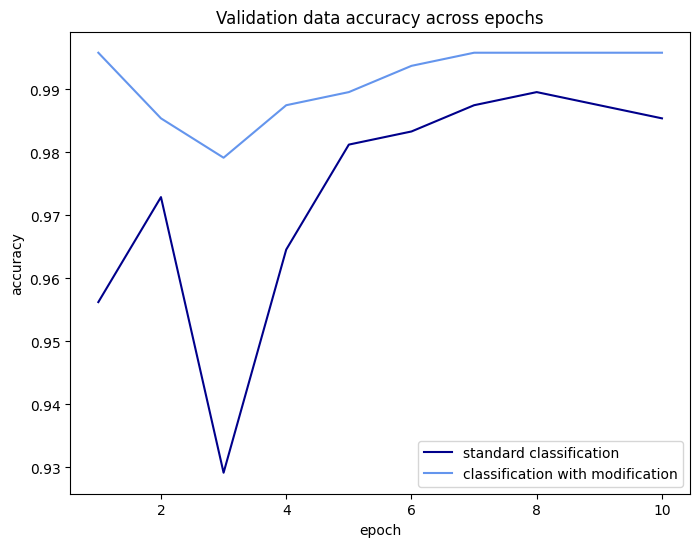

In [6]:
vis_silence_detection_accuracy('data_for_vis/accuracy_silence_detection_.csv')

### Silence detection on the test data 

In [5]:
model_silence_detection = Wav2Vec2ForCTC.from_pretrained("model_silence_detection")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
audio_dir = "./data/train/audio/"

with open("./data/train/testing_with_silence_list.txt", "r") as file:
    testing_audio_files = [line.strip() for line in file]
    
correct_silence_predictions = 0
total_files = len(testing_audio_files)

with open('./data/train/testing_non_silent_files.txt', 'w') as f:
    for audio_file in testing_audio_files:
        audio, rate = librosa.load(os.path.join(audio_dir, audio_file), sr=16000)
        inputs = processor(audio, return_tensors="pt", padding=True, sampling_rate=16000)
        with torch.no_grad():
            logits = model_silence_detection(inputs.input_values).logits

        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = processor.decode(predicted_ids[0])
        if len(transcription)>0:
            predicted_label = 'sound'
            f.write(f'{audio_file}\n')
        else:
            predicted_label = 'silence'
        
        true_label = audio_file.split('/')[0]
        if true_label == 'silence':
            if predicted_label == 'silence':
                correct_silence_predictions += 1
        else:
            if predicted_label != 'silence':
                correct_silence_predictions += 1

accuracy = correct_silence_predictions / total_files
print(f'Accuracy of silence detection: {accuracy * 100}%')

Accuracy of silence detection: 99.8756390769656%


## Speech classification
### Original model inference

In [12]:
predict_on_dataset(model, processor, dataset_test)

NameError: name 'dataset_valid' is not defined

### Fine-tune & adjust speech classification model

In [6]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
model.freeze_feature_extractor()
model.to(device)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You sho

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

In [5]:
shutil.rmtree('./logs', ignore_errors=True)

In [6]:
def train_adjusted_model(lr):
    training_args = TrainingArguments(
        output_dir="./output_dir",
        per_device_train_batch_size=16,
        num_train_epochs=20,
        logging_dir="./logs",
        save_strategy='epoch', 
        evaluation_strategy='epoch',
        learning_rate=lr
    )

    def compute_metrics(pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)

        labels = [list(item[0]) for item in labels]
        if all(isinstance(i, list) for i in preds):
            preds = [item for sublist in preds for item in sublist]
        pred_transcriptions = processor.batch_decode(preds)
        true_transcriptions = processor.batch_decode(labels)
        wer_score = wer(true_transcriptions, pred_transcriptions)
        cer_score = cer(true_transcriptions, pred_transcriptions)

        correct_predictions = sum([true == pred for true, pred in zip(true_transcriptions, pred_transcriptions)])
        total_predictions = len(true_transcriptions)
        accuracy = correct_predictions / total_predictions

        available_labels = get_available_labels('data/train/audio/')
        cer_score_closest, accuracy_closest = compute_metrics_with_closest_label(available_labels, pred_transcriptions, true_transcriptions)

        return {"wer": wer_score, "accuracy": accuracy, "cer": cer_score, "accuracy_closest": accuracy_closest, "cer_closest": cer_score_closest}


    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset_train,
        eval_dataset=dataset_valid,
        tokenizer=processor,
        compute_metrics=compute_metrics,
        callbacks=[SaveMetricsCallback(dataset_valid, lr)],
    )

    trainer.train()
    trainer.save_model(f"model_lr_{lr}")

In [7]:
# lrs = [0.0001, 0.000005, 0.00001, 0.000005]
lrs = [0.0001, 0.000005]
for lr in lrs:
    train_adjusted_model(lr)

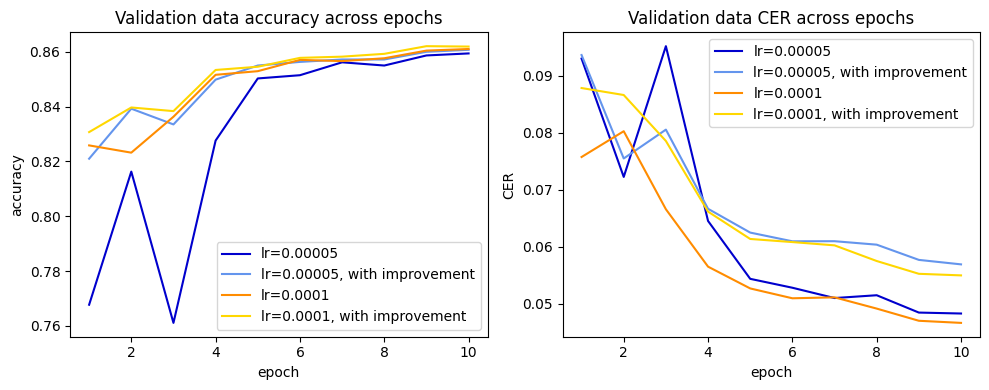

In [3]:
vis_accuracy_cer("data_for_vis/validation_metrics_5e-05.csv", "data_for_vis/validation_metrics_0.0001.csv")

### Prediction on test data 

In [22]:
model_speech_classification = Wav2Vec2ForCTC.from_pretrained("model_lr_0.0001")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
audio_dir = "./data/train/audio/"
available_labels = get_available_labels("./data/train/audio/")

with open("./data/train/testing_non_silent_files.txt", "r") as file:
    testing_speech_files = [line.strip() for line in file]
    
correct_silence_predictions = 0
total_cer = 0
total_cer_org = 0
correct_speech_predictions = 0
correct_speech_predictions_org = 0

with open('./data/train/testing_classification.txt', 'w') as f:
    for audio_file in testing_speech_files:
        audio, rate = librosa.load(os.path.join(audio_dir, audio_file), sr=16000)
        inputs = processor(audio, return_tensors="pt", padding=True, sampling_rate=16000)
        with torch.no_grad():
            logits = model_speech_classification(inputs.input_values).logits

        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = processor.decode(predicted_ids[0])

        true_label = audio_file.split('/')[0]
        closest_label = min(available_labels, key=lambda l: Levenshtein.distance(l, transcription)).lower()
        if closest_label == true_label:
            correct_speech_predictions += 1
        total_cer += cer(true_label, closest_label)
        if transcription == true_label:
            correct_speech_predictions_org += 1
        total_cer_org += cer(true_label, transcription)
        f.write(f'{audio_file},{closest_label}\n')

accuracy_speech = correct_speech_predictions / len(testing_speech_files)
my_cer = total_cer / len(testing_speech_files)
print(f'Accuracy of speech classification: {accuracy_speech * 100}%')
print(f'CER of speech classification: {my_cer * 100}%')
print(f'Accuracy of speech classification org: {correct_speech_predictions_org / len(testing_speech_files) * 100}%')
print(f'CER of speech classification org : {total_cer_org / len(testing_speech_files) * 100}%')

Accuracy of speech classification: 98.40316437152066%
CER of speech classification: 1.272829377868933%


## Prediction on competition dataset

In [23]:
model_silence_detection = Wav2Vec2ForCTC.from_pretrained("model_silence_detection")
model_speech_classification = Wav2Vec2ForCTC.from_pretrained("model_lr_0.0001")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
audio_dir = "./data/test/audio/"


def predict_for_competition_approach_1(model_silence_detection, model_speech_classification, processor, audio_dir):
    available_labels = get_available_labels(audio_dir)
    labels_to_classify = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
    with open('./data/test/prediction_approach_1.csv', 'w') as f:
        f.write(f'fname,label\n')
        for audio_file in os.listdir("./data/test/audio"):
            audio, rate = librosa.load(os.path.join(audio_dir, audio_file), sr=16000)
            inputs = processor(audio, return_tensors="pt", padding=True, sampling_rate=16000)
            with torch.no_grad():
                logits = model_silence_detection(inputs.input_values).logits
    
            predicted_ids = torch.argmax(logits, dim=-1)
            transcription = processor.decode(predicted_ids[0])
            if len(transcription)>0:
                with torch.no_grad():
                    logits = model_speech_classification(inputs.input_values).logits
    
                predicted_ids = torch.argmax(logits, dim=-1)
                transcription = processor.decode(predicted_ids[0])
                closest_label = min(available_labels, key=lambda l: Levenshtein.distance(l, transcription)).lower()
                if closest_label in labels_to_classify:
                    f.write(f'{audio_file},{closest_label}\n')
                else:
                    f.write(f'{audio_file},unknown\n')
            else:
                f.write(f'{audio_file},silence\n')

# Second approach: classification with silence as class

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

